In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import tqdm
import datetime

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 5000)

import plotly.io as pio
pio.templates.default = 'simple_white'
from bertopic import BERTopic

## Loading data

In [3]:
df = pd.read_csv('hotel_reviews_with_transl.csv', sep = '\t')
df.sample(3)

,id,hotel,review,lang,reviews_transl,review_transl,reviews_len
2682,2833,Travelodge,"A great place to recharge when on vacation My fiancee and I stayed for only one night. I posted four pictures that you hopefully will find useful.+ The room was well furnished and very clean. If you need a quite and clean place to rest, then this is for you. Close to the Tower Hill Substation.- Bed is very soft. LCD TV cannot be tilted so it's difficult to watch in bed.",en,"A great place to recharge when on vacation My fiancee and I stayed for only one night. I posted four pictures that you hopefully will find useful.+ The room was well furnished and very clean. If you need a quite and clean place to rest, then this is for you. Close to the Tower Hill Substation.- Bed is very soft. LCD TV cannot be tilted so it's difficult to watch in bed.","A great place to recharge when on vacation My fiancee and I stayed for only one night. I posted four pictures that you hopefully will find useful.+ The room was well furnished and very clean. If you need a quite and clean place to rest, then this is for you. Close to the Tower Hill Substation.- Bed is very soft. LCD TV cannot be tilted so it's difficult to watch in bed.",372.00
3382,3577,Park Plaza,"rooms not up to standard but not really the staff's fault Having chosen the park Plaza for its location and we had stayed at the park Plaza Westminster before and having a fab stay. In a excutive suite. We were looking forward to re- living the experiance.Although centrally located for great shopping walking and restaurants, the park Plaza seemed dingy to say the least. The rooms were tired, marks and stains to furniture and carpets, curtains thin and ill fitting, rooms felt cold and un loved. The sliding door to the open terrace could not be locked and i found the place a little depressing. The staff on reception were friendly enough and we were invited to enjoy an excutive lounge were there were free drinks, canapes &amp; papers - yet another dull room, with hard chairs, bright lights very poor drinks selection and canapes? some sort of chicken mousse sausage thing sliced and served on a cracker (tasted of nothing) and a bowl of chinese rice crackers! if you are giving away anything give good or not at all.The location is great for station and many eating houses! but the Westiminter park plaza is leagues ahead far nicer, cosy, contempory styling and a much warmer feeling.",en,"rooms not up to standard but not really the staff's fault Having chosen the park Plaza for its location and we had stayed at the park Plaza Westminster before and having a fab stay. In a excutive suite. We were looking forward to re- living the experiance.Although centrally located for great shopping walking and restaurants, the park Plaza seemed dingy to say the least. The rooms were tired, marks and stains to furniture and carpets, curtains thin and ill fitting, rooms felt cold and un loved. The sliding door to the open terrace could not be locked and i found the place a little depressing. The staff on reception were friendly enough and we were invited to enjoy an excutive lounge were there were free drinks, canapes &amp; papers - yet another dull room, with hard chairs, bright lights very poor drinks selection and canapes? some sort of chicken mousse sausage thing sliced and served on a cracker (tasted of nothing) and a bowl of chinese rice crackers! if you are giving away anything give good or not at all.The location is great for station and many eating houses! but the Westiminter park plaza is leagues ahead far nicer, cosy, contempory styling and a much warmer feeling.","rooms not up to standard but not really the staff's fault Having chosen the park Plaza for its location and we had stayed at the park Plaza Westminster before and having a fab stay. In a excutive suite. We were looking forward to re- living the experiance.Although centrally located for great shopping walking and restaurants, the park Plaza seemed dingy to say the 

In [4]:
docs = list(df.reviews_transl)
docs[:3]

["We stayed three nights over Thanksgiving weekend. While it's a ways out of downtown London, the little town it's in is great--lots of delicious restaurants, inexpensive shopping, close to a fairly major highway. Our two rooms were spare but comfortable and very clean. Bathrooms were fine. Mattresses were sad, saggy and lumpy, but at least not rock hard and the sheets fit and stayed on well. The comforter was just the perfect weight for the weather--we all slept well. There's an in-house restaurant with room service, which we never had a chance to use. The a la carte prices were reasonable, except the buffet breakfast, which was high. It's difficult to find the parking lots, but once you figure out the one way streets and round-abouts, there is safe, adequate parking. We'd go back. For only nine pounds a night for two people, it's a great bargain!",
 "very uncomfortable stay We were staying at his hotel only because my father couldnt make it and rather than cancel the rooms we took hi

## Building default model

In [5]:
%%time

# Create a BERTopic model and fit it to the documents
topic_model = BERTopic()
topics, ini_probs = topic_model.fit_transform(docs)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


CPU times: user 20min 11s, sys: 24.5 s, total: 20min 35s
Wall time: 3min 29s


In [6]:
# Get the number of topics. -1 because of the -1 topic for outliers.
num_topics = len(topic_model.get_topics()) - 1
num_topics

101

In [7]:
# Get the topic information and display the top 10 topics
# 6344 reviews were not assigned to any topic and are labeled as -1 (outliers).
topic_model.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

,Count,Name,Representation
Topic,,,
-1,6118,-1_the_and_to_was,"[the, and, to, was, in, for, of, we, room, it]"
0,625,0_very_hotel_great_good,"[very, hotel, great, good, was, location, and, stay, nice, staff]"
1,387,1_london_hotel_great_location,"[london, hotel, great, location, stay, and, very, nice, stayed, is]"
2,261,2_noise_noisy_the_sleep,"[noise, noisy, the, sleep, room, in, was, of, to, but]"
3,237,3_paddington_heathrow_station_hilton,"[paddington, heathrow, station, hilton, express, the, to, is, and, in]"
4,205,4_victoria_plaza_park_station,"[victoria, plaza, park, station, and, the, hotel, we, to, great]"
5,185,5_gloucester_tube_road_and,"[gloucester, tube, road, and, the, is, hotel, was, location, in]"
6,167,6_hilton_london_bridge_the,"[hilton, london, bridge, the, is, of, and, tower, to, in]"
7,129,7_bonnington_the_and_was,"[bonnington, the, and, was, we, to, in, at, room, it]"


In [8]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [9]:
# クラスごとのトピック分布を計算し、可視化する
# normalize_frequency = True の解釈については以下を参照: 各クラスまたは各トピックの値の合計を 1 にするものではなく、
# トピック間の相対的なトレンドを比較しやすくするために、トピックごとに各クラスの頻度ベクトルを L2 正規化をしているだけ
# https://github.com/MaartenGr/BERTopic/issues/446
# https://github.com/MaartenGr/BERTopic/blob/de7376d3d42960e787a1115e5fe69fb726a7a33d/bertopic/plotting/_topics_per_class.py#L90
topics_per_class = topic_model.topics_per_class(docs, classes=df.hotel)
fig = topic_model.visualize_topics_per_class(
    topics_per_class,
    top_n_topics=10,
    normalize_frequency = True
)

fig.write_html('basic.html')
fig.show()

In [10]:
# 各レビューに割り当てられたトピックをデータフレームに追加
df['basic_topic'] = topics

## Dealing with the outliers

### Improving the topic model

In [11]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation'] + extra_cols]

In [12]:
#!uv pip install pip
#!uv run python -m spacy download en_core_web_sm

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2 
}

vectorizer_model = CountVectorizer(min_df=5, stop_words = 'english')
topic_model = BERTopic(nr_topics = 'auto',
                       vectorizer_model = vectorizer_model,
                       representation_model = representation_model)
topics, ini_probs = topic_model.fit_transform(docs)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [15]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

96

In [16]:
get_topic_stats(topic_model, ['Aspect1', 'Aspect2']).head(7).set_index('Topic')

,Count,Share,CumulativeShare,Name,Representation,Aspect1,Aspect2
Topic,,,,,,,
-1,6310,51.48,51.48,-1_hotel_hotels_rooms_london,"[hotel, hotels, rooms, london, inn, room, hilton, booked, place, restaurant]","[room, hotel, good, breakfast, staff, stay, location, rooms, clean, night]","[hotels, london, room, booked, restaurant, park, bus, station, shower, bar]"
0,408,3.33,54.81,0_hotels_hotel_london_visit,"[hotels, hotel, london, visit, rooms, place, restaurants, nearby, oxford, staying]","[great, hotel, location, good, stay, tube, excellent, central, value, clean]","[hotels, london, place, restaurants, oxford, booked, comfortable, bus, recommend, gardens]"
1,396,3.23,58.04,1_hotel_restaurant_restaurants_rooms,"[hotel, restaurant, restaurants, rooms, place, pleasant, location, buffet, spacious, reviews]","[great, nice, location, staff, stay, excellent, hotel, friendly, good, helpful]","[hotel, restaurants, rooms, location, spacious, concierge, reception, enjoyed, experience, staff]"
2,296,2.41,60.45,2_hotel_rooms_noise_noisy,"[hotel, rooms, noise, noisy, london, quieter, room, bed, quiet, doors]","[noise, noisy, sleep, room, night, window, hotel, road, floor, sound]","[rooms, noisy, london, doors, nights, reception, earplugs, travelodge, sleeper, heard]"
3,263,2.15,62.60,3_london_victoria_hotel_buckingham,"[london, victoria, hotel, buckingham, hotels, park, palace, attractions, gatwick, place]","[plaza, park, station, gatwick, great, hotel, location, modern, palace, train]","[london, victoria, hotels, palace, station, airport, lounge, plaza, bathrooms, express]"
4,232,1.89,64.49,4_paddington_heathrow_london_hotel,"[paddington, heathrow, london, hotel, hotels, hilton, rooms, airport, bathroom, station]","[paddington, heathrow, express, hilton, station, train, hotel, great, location, airport]","[paddington, heathrow, hotels, airport, lounge, metropole, starbucks, hyde, definitely, underground]"
5,181,1.48,65.97,5_hotel_hotels_hilton_london,"[hotel, hotels, hilton, london, hiltons, rooms, thames, lounge, restaurant, restaurants]","[bridge, tower, executive, metropole, lounge, hiltons, hotel, good, nice, breakfast]","[hotels, hilton, thames, lounge, tower, kensington, bed, experience, station, pool]"


In [17]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [18]:
df['basic_topic'] = topics

In [19]:
topic_model.visualize_topics()

### Reducing the number of topics

#### Finding similar topics
https://github.com/MaartenGr/BERTopic/issues/292

In [20]:
topic_model.visualize_heatmap(n_clusters = 20)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
# トピック埋め込みのコサイン類似度行列を計算
distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))

In [23]:
# コサイン類似度行列をデータフレームに変換
dist_df = pd.DataFrame(distance_matrix,
                       columns=topic_model.topic_labels_.values(), 
                       index=topic_model.topic_labels_.values())

In [24]:
# コサイン類似度行列をトピックペアの距離データフレームに変換
tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

In [25]:
pair_dist_df

,topic1,topic2,distance
0,-1_hotel_hotels_rooms_london,-1_hotel_hotels_rooms_london,1.00
1,-1_hotel_hotels_rooms_london,0_hotels_hotel_london_visit,0.92
2,-1_hotel_hotels_rooms_london,1_hotel_restaurant_restaurants_rooms,0.89
3,-1_hotel_hotels_rooms_london,2_hotel_rooms_noise_noisy,0.84
4,-1_hotel_hotels_rooms_london,3_london_victoria_hotel_buckingham,0.89
...,...,...,...
9404,95_london_hotel_rooms_tourist,91_hotel_london_piccadilly_rooms,0.91
9405,95_london_hotel_rooms_tourist,92_lodge_london_lodges_visiting,0.78
9406,95_london_hotel_rooms_tourist,93_hotel_accommodation_lounge_restaurant,0.66
9407,95_london_hotel_rooms_tourist,94_hotel_london_covent_restaurant,0.85


In [26]:
# -1 トピックを除外
pair_dist_df = pair_dist_df[
    (pair_dist_df.topic1.map(lambda x: not x.startswith('-1'))) & 
    (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))
]

In [27]:
# トピックペアの距離データフレームから、トピック1 < トピック2 の条件を満たす行のみを抽出
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]

In [28]:
# トピックペアの距離データフレームを距離の降順でソートし、上位30件を表示
pair_dist_df.sort_values('distance', ascending = False).head(30)

,topic1,topic2,distance
5102,51_hotel_hotels_bedroom_rooms,57_hotel_hotels_london_rooms,0.96
193,0_hotels_hotel_london_visit,95_london_hotel_rooms_tourist,0.95
5054,51_hotel_hotels_bedroom_rooms,9_london_hotel_rooms_liverpool,0.94
6300,63_hotel_london_piccadilly_inns,91_hotel_london_piccadilly_rooms,0.94
149,0_hotels_hotel_london_visit,51_hotel_hotels_bedroom_rooms,0.94
5636,57_hotel_hotels_london_rooms,9_london_hotel_rooms_liverpool,0.93
1687,16_hotel_hotels_rooms_restaurant,37_hotel_hotels_london_rooms,0.93
3696,37_hotel_hotels_london_rooms,9_london_hotel_rooms_liverpool,0.93
4037,40_hotel_rooms_hotels_room,59_hotel_rooms_room_guests,0.93
4181,42_hotel_hotels_booking_inn,9_london_hotel_rooms_liverpool,0.92


In [29]:
# トピック0, 7, 4, 43 をマージ
topic_model.merge_topics(docs, [[0, 7, 4, 43]])

In [30]:
def get_topic_representation(topic_model, topic):
    data = topic_model.get_topic(topic)
    
    return ', '.join(list(map(lambda x: x[0], data)))

# トピックのマージ後のトピック割り当てをデータフレームに追加
df['merged_topic'] = topic_model.topics_
df['merged_topic_repr'] = df['merged_topic'].map(lambda x: get_topic_representation(topic_model, x))

In [31]:
# マージ前とマージ後のトピック割り当ての違いを確認
df[df.merged_topic != df.basic_topic].shape[0], df.merged_topic.nunique()

(4570, 94)

In [32]:
num_topics = len(topic_model.get_topics()) - 1
num_topics

93

In [33]:
get_topic_stats(topic_model).head(10)

,Topic,Count,Share,CumulativeShare,Name,Representation
0,-1,6310,51.48,51.48,-1_hotel_hotels_rooms_london,"[hotel, hotels, rooms, london, inn, room, hilton, booked, place, restaurant]"
1,0,843,6.88,58.35,0_paddington_heathrow_london_southwark,"[paddington, heathrow, london, southwark, hotel, hotels, rooms, hilton, place, room]"
2,1,396,3.23,61.58,1_hotel_restaurant_restaurants_rooms,"[hotel, restaurant, restaurants, rooms, place, pleasant, location, buffet, spacious, reviews]"
3,2,296,2.41,64.00,2_hotel_rooms_noise_noisy,"[hotel, rooms, noise, noisy, london, quieter, room, bed, quiet, doors]"
4,3,263,2.15,66.14,3_victoria_london_hotel_park,"[victoria, london, hotel, park, buckingham, hotels, palace, attractions, gatwick, station]"
5,4,181,1.48,67.62,4_hotel_hotels_hilton_hiltons,"[hotel, hotels, hilton, hiltons, london, rooms, lounge, thames, restaurant, restaurants]"
6,5,178,1.45,69.07,5_covent_hotel_hotels_london,"[covent, hotel, hotels, london, soho, rooms, theatreland, theatre, facilities, booked]"
7,6,146,1.19,70.26,6_hotel_hotels_oxford_rooms,"[hotel, hotels, oxford, rooms, booking, st, street, booked, location, shops]"
8,7,139,1.13,71.40,7_london_hotel_rooms_liverpool,"[london, hotel, rooms, liverpool, cheap, budget, booked, cost, expensive, room]"
9,8,139,1.13,72.53,8_rooms_hotel_room_bathroom,"[rooms, hotel, room, bathroom, carpets, carpet, curtains, shower, bath, smell]"


In [34]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [35]:
topic_model.visualize_topics()

### Approximate Topic Distributions

In [36]:
# トピック分布の近似を計算
# topic_distr: 各ドキュメントに対するトピックの分布（確率）
# topic_token_distr: 各ドキュメントに対するトピックごとのトークンの分布（確率）
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, window = 4, calculate_tokens=True)

In [37]:
topic_distr.shape, topic_token_distr[0].shape, topic_token_distr[1].shape

((12258, 93), (145, 93), (323, 93))

Text(0.5, 1.0, 'Distribution of topic non-zero probabilities')

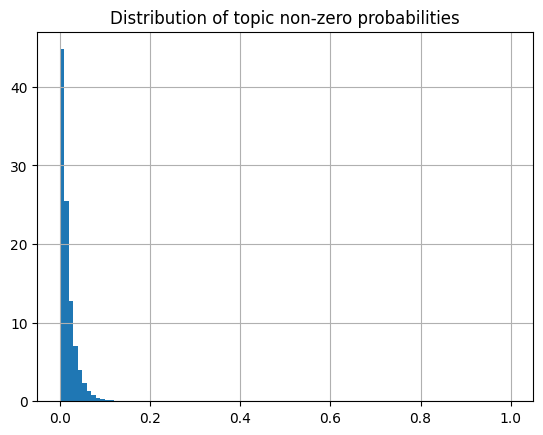

In [38]:
# topic_distr の非ゼロの値の分布をヒストグラムで表示
raw_distr = pd.Series(topic_distr.ravel())
raw_distr = raw_distr[raw_distr > 0]

ax = raw_distr.hist(bins = 100, range = [0, 1],
                                        weights = np.ones_like(raw_distr)*100/raw_distr.shape[0])
ax.set_title('Distribution of topic non-zero probabilities')

In [39]:
topic_distr.shape

(12258, 93)

In [40]:
# 各ドキュメントに対するトピックの分布の最大値をデータフレームに追加
df['max_topic_distr'] = topic_distr.max(axis = 1)

In [41]:
# 各ドキュメントに対するトピックの分布の最大値が 0.05 より大きいドキュメントの割合を計算
1 - df[df.max_topic_distr > 0.05].shape[0]/df.shape[0]

0.04168706151085011

In [42]:
df = df.reset_index(drop=True)

In [43]:
# 各ドキュメントに対するトピックの分布の最大値が 0.1 より大きく、かつレビューの長さが 100 以下のドキュメントをランダムに 10 件表示
df[(df.max_topic_distr > 0.1) & (df.reviews_len <= 100)].sample(10)

,id,hotel,review,lang,reviews_transl,review_transl,reviews_len,basic_topic,merged_topic,merged_topic_repr,max_topic_distr
3802,3998,Park Plaza,"Great Hotel! Great Hotel, Perfect Location, Spotless. Had a wonderful time",en,"Great Hotel! Great Hotel, Perfect Location, Spotless. Had a wonderful time","Great Hotel! Great Hotel, Perfect Location, Spotless. Had a wonderful time",74.00,19,17,"hotels, hotel, accommodation, tourist, location, place, located, rooms, city, central",0.15
10534,11088,Holiday Inn,Highly Recommend HIExpress-Earl's Court,en,Highly Recommend HIExpress-Earl's Court,Highly Recommend HIExpress-Earl's Court,39.00,-1,-1,"hotel, hotels, rooms, london, inn, room, hilton, booked, place, restaurant",0.41
9080,9533,Millemiun,Really nice experience,en,Really nice experience,Really nice experience,22.00,33,32,"experience, pleasantly, excellent, fantastic, disappointment, great, terrible, disappointed, wonderful, nice",0.45
1234,1302,Travelodge,Only stay if you get a discounted offer.....,en,Only stay if you get a discounted offer.....,Only stay if you get a discounted offer.....,44.00,-1,-1,"hotel, hotels, rooms, london, inn, room, hilton, booked, place, restaurant",0.34
12252,12876,Hilton,Un buon albergo per un viaggio di lavoro,it,A good hotel for a business trip,A good hotel for a business trip,32.00,19,17,"hotels, hotel, accommodation, tourist, location, place, located, rooms, city, central",0.23
6272,6608,Holiday Inn,Bestes Preis-/Leistungsverhältniss,de,Best price/performance ratio,Best price/performance ratio,28.00,79,75,"quality, price, value, discounted, excellent, luxury, great, best, good, definitely",1.00
9370,9852,Park Plaza,Un magnífico hotel nuevo y bien situado,es,A magnificent new and well located hotel,A magnificent new and well located hotel,40.00,19,17,"hotels, hotel, accommodation, tourist, location, place, located, rooms, city, central",0.54
9647,10134,Radisson,Good but not great (other than location),en,Good but not great (other than location),Good but not great (other than location),40.00,35,33,"comfortable, comfort, affordable, pleasant, practical, convenience, convenient, located, inexpensive, location",0.11
10530,11080,Holiday Inn,Modern smart but small rooms and suprisingly noisy,en,Modern smart but small rooms and suprisingly noisy,Modern smart but small rooms and suprisingly noisy,50.00,2,2,"hotel, rooms, noise, noisy, london, quieter, room, bed, quiet, doors",0.15
5682,5979,Holiday Inn,Gutes günstiges Vorstadthotel mit guter Verkehrsanbindung,de,Good cheap suburban hotel with good transport connections,Good cheap suburban hotel with good transport connections,57.00,50,48,"hotels, hotel, marriott, hilton, facilities, restaurant, places, pubs, quality, worth",0.63


In [44]:
doc_id = 11408

In [45]:
# doc_id のドキュメントに対するトピックの分布を可視化
topic_model.visualize_distribution(topic_distr[doc_id], min_probability=0.05)

In [46]:
# workaround for https://github.com/dexplo/dataframe_image/issues/74
print(pd.__version__)
pd.io.formats.style.Styler.applymap = pd.io.formats.style.Styler.map

3.0.1


In [47]:
docs[doc_id], topic_token_distr[doc_id].shape

('Fantastic hotel located on the banks of the Thames', (9, 93))

In [48]:
# トークンレベルのトピック分布を可視化
vis_df = topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])
vis_df

,Fantastic,hotel,located,on,the,banks,of,the,Thames
17_hotels_hotel_accommodation_tourist,0.222,0.505,0.505,0.505,0.283,0.000,0.000,0.000,0.000
33_comfortable_comfort_affordable_pleasant,0.164,0.396,0.396,0.396,0.232,0.000,0.000,0.000,0.000
49_thames_hotel_london_attractions,0.000,0.000,0.000,0.000,0.000,0.243,0.243,0.243,0.243
87_london_amenities_rooms_inexpensive,0.109,0.225,0.225,0.225,0.116,0.000,0.000,0.000,0.000


In [49]:
# トピック分布の閾値を 0 から 0.15 まで 0.001 刻みで変化させながら、各ドキュメントに対して閾値以上のトピックの数をカウントし、その分布をデータフレームにまとめる
tmp_dfs = []

for thr in tqdm.tqdm(np.arange(0, 0.15, 0.001)):
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1
    tmp_df['num_topics_group'] = tmp_df['num_topics'].map(lambda x: str(x) if x < 5 else '5+')
    
    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr
    
    tmp_dfs.append(tmp_df_aggr)

100%|██████████| 150/150 [00:08<00:00, 17.48it/s]


In [50]:
# トピック分布の閾値を変化させたときの、各トピック数グループ（0, 1, 2, 3, 4, 5+）のドキュメント数の分布をデータフレームにまとめる
num_topics_stats_df = pd.concat(tmp_dfs).pivot(
    index = 'threshold',
    values = 'num_docs',
    columns = 'num_topics_group'
).fillna(0)

In [51]:
# トピック分布の閾値を変化させたときの、各トピック数グループ（0, 1, 2, 3, 4, 5+）のドキュメント数の分布を割合で表示するために、各行を行ごとの合計で割る
num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

In [52]:
print(pd.options.display.precision)

6


In [53]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
num_topics_stats_df

num_topics_group,0,1,2,3,4,5+
threshold,,,,,,
0.000,0.000,0.000,0.000,0.000,0.000,100.000
0.001,0.506,0.897,0.579,0.514,0.351,97.153
0.002,0.506,0.897,0.579,0.514,0.351,97.153
0.003,0.506,0.897,0.579,0.514,0.351,97.153
0.004,0.506,0.897,0.579,0.514,0.351,97.153
...,...,...,...,...,...,...
0.145,88.310,8.060,2.301,1.003,0.245,0.082
0.146,88.424,7.978,2.309,0.971,0.237,0.082
0.147,88.595,7.848,2.292,0.954,0.237,0.073


In [54]:
# トピック分布の閾値を変化させたときの、各トピック数グループ（0, 1, 2, 3, 4, 5+）のドキュメント数の分布を面グラフで表示
colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df, 
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics', 'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      })

In [55]:
threshold = 0.05

# 各ドキュメントに対するトピックの分布の閾値を 0.05 として、閾値以上のトピックを複数持つドキュメントを抽出し、そのトピックのリストをデータフレームに追加
df['multiple_topics'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold, 
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))


tmp_data = []

# 複数トピックを持つドキュメントを複数行に展開し、トピックごとにドキュメントの情報を持つデータフレームを作成
for rec in df.to_dict('records'):
    if len(rec['multiple_topics']) != 0:
        mult_topics = rec['multiple_topics']
    else:
        mult_topics = [-1]

    for topic in mult_topics: 
        tmp_data.append(
            {
                'topic': topic,
                'id': rec['id'],
                'hotel': rec['hotel'],
                'reviews_transl': rec['reviews_transl']
            }
        )

mult_topics_df = pd.DataFrame(tmp_data)

In [56]:
mult_topics_df

,topic,id,hotel,reviews_transl
0,1,0,Travelodge,"We stayed three nights over Thanksgiving weekend. While it's a ways out of downtown London, the little town it's in is great--lots of delicious restaurants, inexpensive shopping, close to a fairly major highway. Our two rooms were spare but comfortable and very clean. Bathrooms were fine. Mattresses were sad, saggy and lumpy, but at least not rock hard and the sheets fit and stayed on well. The comforter was just the perfect weight for the weather--we all slept well. There's an in-house restaurant with room service, which we never had a chance to use. The a la carte prices were reasonable, except the buffet breakfast, which was high. It's difficult to find the parking lots, but once you figure out the one way streets and round-abouts, there is safe, adequate parking. We'd go back. For only nine pounds a night for two people, it's a great bargain!"
1,33,0,Travelodge,"We stayed three nights over Thanksgiving weekend. While it's a ways out of downtown London, the little town it's in is great--lots of delicious restaurants, inexpensive shopping, close to a fairly major highway. Our two rooms were spare but comfortable and very clean. Bathrooms were fine. Mattresses were sad, saggy and lumpy, but at least not rock hard and the sheets fit and stayed on well. The comforter was just the perfect weight for the weather--we all slept well. There's an in-house restaurant with room service, which we never had a chance to use. The a la carte prices were reasonable, except the buffet breakfast, which was high. It's difficult to find the parking lots, but once you figure out the one way streets and round-abouts, there is safe, adequate parking. We'd go back. For only nine pounds a night for two people, it's a great bargain!"
2,34,0,Travelodge,"We stayed three nights over Thanksgiving weekend. While it's a ways out of downtown London, the little town it's in is great--lots of delicious restaurants, inexpensive shopping, close to a fairly major highway. Our two rooms were spare but comfortable and very clean. Bathrooms were fine. Mattresses were sad, saggy and lumpy, but at least not rock hard and the sheets fit and stayed on well. The comforter was just the perfect weight for the weather--we all slept well. There's an in-house restaurant with room service, which we never had a chance to use. The a la carte prices were reasonable, except the buffet breakfast, which was high. It's difficult to find the parking lots, but once you figure out the one way streets and round-abouts, there is safe, adequate parking. We'd go back. For only nine pounds a night for two people, it's a great bargain!"
3,65,0,Travelodge,"We stayed three nights over Thanksgiving weekend. While it's a ways out of downtown London, the little town it's in is great--lots of delicious restaurants, inexpensive shopping, close to a fairly major highway. Our two rooms were spare but comfortable and very clean. Bathrooms were fine. Mattresses were sad, saggy and lumpy, but at least not rock hard and the sheets fit and stayed on well. The comforter was just the perfect weight for the weather--we all slept well. There's an in-house restaurant with room service, which we never had a chance to use. The a la carte prices were reasonable, except the buffet breakfast, which was high. It's difficult to find the parking lots, but once you figure out the one way streets and round-abouts, there is safe, adequate parking. We'd go back. For only nine pounds a night for two people, it's a great bargain!"
4,80,0,Travelodge,"We stayed three nights over Thanksgiving weekend. While it's a ways out of downtown London, the little town it's in is great--lots of delicious restaurants, inexpensive shopping, close to a fairly major highway. Our two rooms were spare but comfortable and very clean. Bathrooms were fine. Mattresses were sad, saggy and lumpy, but at least not rock hard and the sheets fit and stayed on well. The comforter was just the perfect weight

## Comparing distributions by hotels

In [57]:
tmp_data = []

# ホテルごと、トピックごとに、ホテルのレビュー数、トピックを持つホテルのレビュー数、その他のホテルのレビュー数、その他のホテルでトピックを持つレビュー数を計算する
for hotel in mult_topics_df.hotel.unique():
    for topic in mult_topics_df.topic.unique():
        tmp_data.append({
            'hotel': hotel,
            'topic_id': topic,
            'total_hotel_reviews': mult_topics_df[mult_topics_df.hotel == hotel].id.nunique(),
            'topic_hotel_reviews': mult_topics_df[(mult_topics_df.hotel == hotel) & (mult_topics_df.topic == topic)].id.nunique(),
            'other_hotels_reviews': mult_topics_df[mult_topics_df.hotel != hotel].id.nunique(),
            'topic_other_hotels_reviews': mult_topics_df[(mult_topics_df.hotel != hotel) & (mult_topics_df.topic == topic)].id.nunique()
        })
        
mult_topics_stats_df = pd.DataFrame(tmp_data)

In [58]:
# ホテルごと、トピックごとに、ホテルのレビュー数に対するトピックを持つレビュー数の割合、その他のホテルのレビュー数に対するトピックを持つレビュー数の割合を計算する
mult_topics_stats_df['topic_hotel_share'] = 100*mult_topics_stats_df.topic_hotel_reviews/mult_topics_stats_df.total_hotel_reviews
mult_topics_stats_df['topic_other_hotels_share'] = 100*mult_topics_stats_df.topic_other_hotels_reviews/mult_topics_stats_df.other_hotels_reviews

In [59]:
#!uv add statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [60]:
# ホテルごと、トピックごとに、ホテルのレビュー数に対するトピックを持つレビュー数の割合と、その他のホテルのレビュー数に対するトピックを持つレビュー数の割合の差の p 値を計算する
mult_topics_stats_df['difference_pval'] = list(map(
    lambda x1, x2, n1, n2: proportions_ztest(
        count = [x1, x2],
        nobs = [n1, n2],
        alternative = 'two-sided'
    )[1],
    mult_topics_stats_df.topic_other_hotels_reviews,
    mult_topics_stats_df.topic_hotel_reviews,
    mult_topics_stats_df.other_hotels_reviews,
    mult_topics_stats_df.total_hotel_reviews
))

In [61]:
# ホテルごと、トピックごとに、ホテルのレビュー数に対するトピックを持つレビュー数の割合と、
# その他のホテルのレビュー数に対するトピックを持つレビュー数の割合の差が有意かどうかを示す列を追加する（p 値が 0.05 以下の場合は 1、それ以外の場合は 0）
mult_topics_stats_df['sign_difference'] = mult_topics_stats_df.difference_pval.map(
    lambda x: 1 if x <= 0.05 else 0
)

def relative_actuality(d, sign):
    sign_percent = 1
    if sign == 0:
        return 'no diff'
    if (d >= -sign_percent) and (d <= sign_percent):
        return 'no diff'
    if d < -sign_percent:
        return 'lower'
    if d > sign_percent:
        return 'higher'

# p 値が 0.05 以下の場合は 'higher' または 'lower'、それ以外の場合は 'no diff' を返す列を追加する
mult_topics_stats_df['diff_significance_total'] = list(map(
    relative_actuality,
    mult_topics_stats_df.topic_hotel_share - mult_topics_stats_df.topic_other_hotels_share,
    mult_topics_stats_df.sign_difference
))

In [62]:
import plotly

def get_color_sign(rel):
    # 'higher' の場合は緑色、'lower' の場合は赤色、'no diff' の場合は灰色を返す
    if rel == 'no diff':
        return plotly.colors.qualitative.Set2[7]
    if rel == 'lower':
        return plotly.colors.qualitative.Set2[1]
    if rel == 'higher':
        return plotly.colors.qualitative.Set2[0]
    
def get_topic_representation_title(topic_model, topic):
    # topic_model.get_topic(topic) は、トピックの上位の単語とその重みのリストを返す。例えば、[(word1, weight1), (word2, weight2), ...] のような形式。
    data = topic_model.get_topic(topic)
    data = list(map(lambda x: x[0], data))
    
    return ', '.join(data[:5]) + ', <br>         ' + ', '.join(data[5:])

def get_graphs_for_topic(t):
    # トピック t に対して、ホテルごとのトピックの割合を示す棒グラフを作成する。
    # グラフの色は、ホテルのトピックの割合がその他のホテルのトピックの割合よりも有意に高い場合は緑色、低い場合は赤色、有意な差がない場合は灰色とする。
    topic_stats_df = mult_topics_stats_df[mult_topics_stats_df.topic_id == t]\
        .sort_values('total_hotel_reviews', ascending = False).set_index('hotel')
    

    colors = list(map(
        get_color_sign,
        topic_stats_df.diff_significance_total
    ))
    
    
    fig = px.bar(topic_stats_df.reset_index(), x = 'hotel', y = 'topic_hotel_share',
                title = 'Topic: %s' % get_topic_representation_title(topic_model, 
                                                            topic_stats_df.topic_id.min()),
                text_auto = '.1f',
                labels = {'topic_hotel_share': 'share of reviews, %'},
                hover_data=['topic_id'])
    fig.update_layout(showlegend = False)
    fig.update_traces(marker_color=colors, marker_line_color=colors,
                  marker_line_width=1.5, opacity=0.9)
    
    
    topic_total_share = 100.*((topic_stats_df.topic_hotel_reviews + topic_stats_df.topic_other_hotels_reviews)\
        /(topic_stats_df.total_hotel_reviews + topic_stats_df.other_hotels_reviews)).min()
    print(topic_total_share)
    
    fig.add_shape(type="line",
        xref="paper",
        x0=0, y0=topic_total_share,
        x1=1, y1=topic_total_share,
        line=dict(
            color=colormap[8],
            width=3, dash="dot"
        )
    )
    
    fig.show()

In [63]:
# トピックごとのユニークなレビュー数を計算するデータフレームを作成する
top_mult_topics_df = mult_topics_df.groupby('topic', as_index = False).id.nunique()

In [64]:
# トピックごとのユニークなレビュー数のデータフレームに、トピックの割合とトピックの代表的な単語を追加する
top_mult_topics_df['share'] = 100.*top_mult_topics_df.id/top_mult_topics_df.id.sum()
top_mult_topics_df['topic_repr'] = top_mult_topics_df.topic.map(
    lambda x: get_topic_representation(topic_model, x)
)

In [65]:
# レビュー数の降順でソートし、上位15件を表示する
top_mult_topics_df = top_mult_topics_df.sort_values('id', ascending = False)
top_mult_topics_df.head(15)

,topic,id,share,topic_repr
2,1,6345,15.451,"hotel, restaurant, restaurants, rooms, place, pleasant, location, buffet, spacious, reviews"
18,17,3962,9.648,"hotels, hotel, accommodation, tourist, location, place, located, rooms, city, central"
1,0,1683,4.098,"paddington, heathrow, london, southwark, hotel, hotels, rooms, hilton, place, room"
26,25,1674,4.077,"hotels, hotel, rooms, booking, budget, cafe, cheap, reviews, booked, room"
56,55,1365,3.324,"hotel, hotels, london, accommodation, londontown, visiting, travelers, uk, trip, near"
49,48,1283,3.124,"hotels, hotel, marriott, hilton, facilities, restaurant, places, pubs, quality, worth"
92,91,1212,2.951,"hotel, london, covent, restaurant, attractions, staff, regent, friendly, welcoming, trip"
35,34,1201,2.925,"location, nearby, place, located, city, neighbourhood, central, local, metro, stations"
46,45,1030,2.508,"rooms, accommodation, hotelthe, room, staff, visitors, tours, renovation, refurbishment, location"
67,66,1002,2.440,"london, thames, value, worth, price, money, bargain, compared, pay, river"


In [66]:
# レビュー数の多いトピック上位32件に対して、ホテルごとのトピックの割合を示す棒グラフを作成する
for t in top_mult_topics_df.head(32).topic.values:
    get_graphs_for_topic(t)

51.76211453744494


32.32174906183717


13.729809104258445


13.656387665198238


11.13558492413118


10.466634034915973


9.887420460107684


9.797683145700766


8.40267580355686


8.174253548702888


7.570566160874531


7.480828846467613


7.170827214880078


6.412139011257954


5.767661935062816


5.335291238374939


4.992657856093979


4.168706151085005


4.103442649698157


3.809756893457334


3.7363354543971288


3.5731767009300053


3.410017947462882


3.410017947462882


3.385544134442813


3.352912383749388


3.3365965084026756


3.303964757709251


3.2305433186490458


3.1000163158753464


3.034752814488497


2.8960678740414423


In [67]:
mult_topics_df[(mult_topics_df.topic == 65) & (mult_topics_df.reviews_transl.map(lambda x: 'refurb' in x))].sample(10)

ValueError: Cannot take a larger sample than population when 'replace=False'